# 0. Setup

Import packages and specify any important functions here.

In [1]:
# import standard python packages
import pandas as pd
import subprocess
import os
import dill
import sys
import datetime

# add the utils and env directories to the path
sys.path.append('../../utils/')
sys.path.append('../../env/')

# import functions from utils directory files
from string_functions import *
from biofile_handling import *

# import paths to software installs from env
from install_locs import *

# 1. Collect BioFileDockets for each starting dataset
Collects BioFileDockets for each of the species datasets in the `species_dict`.

This `dict` expects key:value pairs in the form of `species`:`conditions` and is passed to the MultiSpeciesBioFileDocket class, which creates a folder in `output/` for the analysis.

The folder name takes the following format:

- `species_concat` + `_` + `global_conditions` + `analysis_type`

Where `species_concat` is the string concatenation of the alphabetize list of species prefixes.

In [2]:
################
# general info #
################

species_dict = {
    'Danio_rerio': 'adultbrain',
    'Mus_musculus': 'adultbrain',
    'Xenopus_laevis': 'adultbrain'
}

global_conditions = 'adultbrain'

analysis_type = 'OrthoFinder'

################

sample_MSD = MultiSpeciesBioFileDocket(
    species_dict = species_dict,
    global_conditions = global_conditions,
    analysis_type = analysis_type
    )

sample_MSD.get_BioFileDockets()
sample_MSD.s3_to_local()

/home/ec2-user/glial-origins/output/DrerMmusXlae_adultbrain_OrthoFinder/ already exists
file GCF_000002035.5_GRCz10_genomic.gff already exists at /home/ec2-user/glial-origins/output/Drer_adultbrain/GCF_000002035.5_GRCz10_genomic.gff
file GCF_000002035.5_GRCz10_genomic.fna already exists at /home/ec2-user/glial-origins/output/Drer_adultbrain/GCF_000002035.5_GRCz10_genomic.fna
file GSM3768152_Brain_8_dge.txt already exists at /home/ec2-user/glial-origins/output/Drer_adultbrain/GSM3768152_Brain_8_dge.txt
file Drer_adultbrain_ZFIN_UniProtIDs.txt already exists at /home/ec2-user/glial-origins/output/Drer_adultbrain/Drer_adultbrain_ZFIN_UniProtIDs.txt
file Drer_adultbrain_uniprot-idmm.tsv already exists at /home/ec2-user/glial-origins/output/Drer_adultbrain/Drer_adultbrain_uniprot-idmm.tsv
file Drer_adultbrain_gtf-idmm.tsv already exists at /home/ec2-user/glial-origins/output/Drer_adultbrain/Drer_adultbrain_gtf-idmm.tsv
file GCF_000002035.5_GRCz10_genomic_cDNA.fna already exists at /home/ec2

# 2. Get the peptide file paths from each BioFileDocket

In [3]:
# Extract the peptide file info from the sample_MSD
peptide_files = {pre: sample_MSD.species_BioFileDockets[pre].transdecoder_pep for pre in sample_MSD.species_BioFileDockets}
display(peptide_files)

# Move the files from the starting directory to the OrthoFinder run directory
for pepfile in peptide_files.values():
    start = os.path.abspath(pepfile.path)
    end = sample_MSD.directory + pepfile.filename
    if not os.path.exists(end):
        print('copying', start, 'to', end)
        subprocess.run(['cp', start, end])
    else:
        print('file', start, 'has already been moved')

{'Drer': <biofile_handling.TransdecoderOutFile at 0x7fddc5782b00>,
 'Mmus': <biofile_handling.TransdecoderOutFile at 0x7fddc5783e50>,
 'Xlae': <biofile_handling.TransdecoderOutFile at 0x7fddc57b8e50>}

file /home/ec2-user/glial-origins/output/Drer_adultbrain/GCF_000002035.5_GRCz10_genomic_cDNA.fna.transdecoder.pep has already been moved
file /home/ec2-user/glial-origins/output/Mmus_adultbrain/GCF_000001635.23_GRCm38.p3_genomic_cDNA.fna.transdecoder.pep has already been moved
file /home/ec2-user/glial-origins/output/Xlae_adultbrain/XENLA_9.2_genome_cDNA.fa.transdecoder.pep has already been moved


# 3. Run OrthoFinder on all collected peptide files

Before running, will check if analysis has already been done - if so, continues.

In [4]:
# Generate OrthoFinder run folder information based on today's date
OF_folder = sample_MSD.directory + 'OrthoFinder/'
today = datetime.date.today()
datefolder = OF_folder + 'Results_' + today.strftime('%b%d')
print(datefolder)

# Check of an OrthoFinder folder already exists; if not, runs analysis
if not os.path.exists(OF_folder):
    subprocess.run([ORTHOFINDER_LOC, '-f', sample_MSD.directory])
else:
    print('OF folder already exists at', OF_folder)
    print('Checking for results folder')
    folders = os.listdir(OF_folder)
    datefolder = OF_folder + [i for i in folders if 'Results' in i][0]
    print('Results folder found at', datefolder)

# Generates OrthoGroups file object
orthogroups_file = OrthoFinderOutputFile(
    sampledict = sample_MSD.sampledict,
    species_dict = sample_MSD.species_dict,
    filename = '/'.join(datefolder.split('/')[-2:]) + '/Orthogroups/Orthogroups.tsv'
)

orthogroups_df = pd.read_csv(orthogroups_file.path, sep = '\t')

sample_MSD.add_keyfile('orthogroups_file', orthogroups_file)
display(orthogroups_df)

/home/ec2-user/glial-origins/output/DrerMmusXlae_adultbrain_OrthoFinder/OrthoFinder/Results_Apr07
OF folder already exists at /home/ec2-user/glial-origins/output/DrerMmusXlae_adultbrain_OrthoFinder/OrthoFinder/
Checking for results folder
Results folder found at /home/ec2-user/glial-origins/output/DrerMmusXlae_adultbrain_OrthoFinder/OrthoFinder/Results_Sep28


,Orthogroup,GCF_000001635.23_GRCm38.p3_genomic_cDNA.fna.transdecoder,GCF_000002035.5_GRCz10_genomic_cDNA.fna.transdecoder,XENLA_9.2_genome_cDNA.fa.transdecoder
0,OG0000000,NaN,NaN,"gene10395_t.p1, gene12148_t.p1, gene1307_t.p1,..."
1,OG0000001,rna75711.p2,"gene10036.p1, gene10201.p2, gene10535.p1, gene...",NaN
2,OG0000002,NaN,NaN,"gene2928_t.p3, gene38029_t.p2, gene41218_t.p1,..."
3,OG0000003,NaN,NaN,"gene264_t.p1, rna1157.p2, rna12598.p1, rna1516..."
4,OG0000004,NaN,NaN,"gene50425_t.p1, rna27145.p2, rna34455.p1, rna4..."
...,...,...,...,...
32348,OG0032348,NaN,NaN,"rna97220.p1, rna97221.p1"
32349,OG0032349,NaN,NaN,"rna97260.p1, rna97260.p2"
32350,OG0032350,NaN,NaN,"rna97447.p1, rna97448.p1"
32351,OG0032351,NaN,NaN,"rna97780.p1, rna97781.p2"


# 4. Generate Orthofinder_exc file from gxc file of each starting dataset

In [5]:
gxc_to_exc(sample_MSD = sample_MSD,
           embedding_df = orthogroups_df, 
           exc_file = orthogroups_file)

Using Orthogroup embeddings as expected from OrthoFinder
Orthogroup_excfile already exists at /home/ec2-user/glial-origins/output/Drer_adultbrain/GSM3768152_Brain_8_dge_asOrthogroup.txt skipping
key "Orthogroup_exc" already exists, ignoring
Orthogroup_excfile already exists at /home/ec2-user/glial-origins/output/Mmus_adultbrain/GSM2906405_Brain1_dge_coerced_asOrthogroup.txt skipping
key "Orthogroup_exc" already exists, ignoring
Orthogroup_excfile already exists at /home/ec2-user/glial-origins/output/Xlae_adultbrain/GSM6214268_Xenopus_brain_COL65_dge_asOrthogroup.txt skipping
key "Orthogroup_exc" already exists, ignoring


# 5. Generate merged exc file for all samples in dataset

In [6]:
collector_df = pd.DataFrame()

display(collector_df)
export_filename = '_'.join([sample_MSD.species_concat, sample_MSD.global_conditions, 'asOrthogroup', 'combined_exc.tsv'])

jointexc = JointExcFile(
    species_dict = sample_MSD.species_dict,
    sampledict = sample_MSD.sampledict,
    filename = export_filename,
    embedding = 'Orthogroup',
    sources = [sample_MSD.species_BioFileDockets[pre].Orthogroup_exc for pre in sample_MSD.species_BioFileDockets]
)

if not os.path.exists(jointexc.path):

    # Iterates through all of the species in the Species BioFileDocket
    for i, pre in enumerate(sample_MSD.species_BioFileDockets.keys()):
    
        df = pd.read_csv(sample_MSD.species_BioFileDockets[pre].Orthogroup_exc.path, sep = '\t')
        df = df.add_prefix(pre + '_')
        df.rename(columns = {pre + '_' + 'Orthogroup': 'Orthogroup'}, inplace = True)
    
        if i == 0:
            collector_df = df
        else:
            collector_df = collector_df.merge(df, on = 'Orthogroup', how = 'inner')

    collector_df.to_csv(jointexc.path, sep = '\t', index = None)

# Iterates through all of the species in the Species BioFileDocket
for pre in sample_MSD.species_BioFileDockets.keys():
    sample_MSD.species_BioFileDockets[pre].add_keyfile('Orthogroup_jointexc', jointexc)

""


key "Orthogroup_jointexc" already exists, ignoring
key "Orthogroup_jointexc" already exists, ignoring
key "Orthogroup_jointexc" already exists, ignoring


# 6. Pickle the species_BioFileDocket files

In [7]:
for pre in sample_MSD.species_BioFileDockets.keys():
    sample_MSD.species_BioFileDockets[pre].local_to_s3()
    sample_MSD.species_BioFileDockets[pre].pickle()
    sample_MSD.species_BioFileDockets[pre].push_to_s3(overwrite = True)

GCF_000002035.5_GRCz10_genomic.gff already exists in S3 bucket, skipping upload. set overwrite = True to overwrite the existing file.
GCF_000002035.5_GRCz10_genomic.fna already exists in S3 bucket, skipping upload. set overwrite = True to overwrite the existing file.
GSM3768152_Brain_8_dge.txt already exists in S3 bucket, skipping upload. set overwrite = True to overwrite the existing file.
Drer_adultbrain_ZFIN_UniProtIDs.txt already exists in S3 bucket, skipping upload. set overwrite = True to overwrite the existing file.
Drer_adultbrain_uniprot-idmm.tsv already exists in S3 bucket, skipping upload. set overwrite = True to overwrite the existing file.
Drer_adultbrain_gtf-idmm.tsv already exists in S3 bucket, skipping upload. set overwrite = True to overwrite the existing file.
GCF_000002035.5_GRCz10_genomic_cDNA.fna already exists in S3 bucket, skipping upload. set overwrite = True to overwrite the existing file.
GCF_000002035.5_GRCz10_genomic_cDNA.fna.transdecoder.bed already exists 

In [8]:
sample_MSD.pickle()
sample_MSD.push_to_s3(overwrite = True)

DrerMmusXlae_adultbrain_OrthoFinder_MultiSpeciesBioFileDocket.pkl already exists in S3 bucket; overwriting.
upload: ../../output/DrerMmusXlae_adultbrain_OrthoFinder/DrerMmusXlae_adultbrain_OrthoFinder_MultiSpeciesBioFileDocket.pkl to s3://arcadia-reference-datasets/glial-origins-pkl/DrerMmusXlae_adultbrain_OrthoFinder_MultiSpeciesBioFileDocket.pkl


In [29]:
og_df = pd.read_csv(sample_MSD.orthogroups_file.path, sep = '\t', names = ['Orthogroup', 'Mmus', 'Drer', 'Xlae'], skiprows = 1)

species_colordict = {'Drer': 'arcadia:aster',
                    'Mmus': 'arcadia:rose',
                    'Xlae': 'arcadia:seaweed'}

col_unpacker = lambda x: x.split(',') if type(x) == str else []

for col in species_colordict.keys():
    og_df[col] = og_df[col].apply(col_unpacker)
    og_df[col + '_size'] = og_df[col].apply(lambda x: len(x))

og_df['full_list'] = og_df['Mmus'] + og_df['Drer'] + og_df['Xlae']
og_df['size'] = og_df['full_list'].apply(lambda x: len(x))

for col in species_colordict.keys():
    og_df[col + '_fraction'] = og_df[col + '_size'] / og_df['size']

display(og_df)

,Orthogroup,Mmus,Drer,Xlae,Drer_size,Mmus_size,Xlae_size,full_list,size,Drer_fraction,Mmus_fraction,Xlae_fraction
0,OG0000000,[],[],"[gene10395_t.p1, gene12148_t.p1, gene1307_t....",0,0,334,"[gene10395_t.p1, gene12148_t.p1, gene1307_t....",334,0.000000,0.000000,1.0
1,OG0000001,[rna75711.p2],"[gene10036.p1, gene10201.p2, gene10535.p1, ...",[],304,1,0,"[rna75711.p2, gene10036.p1, gene10201.p2, ge...",305,0.996721,0.003279,0.0
2,OG0000002,[],[],"[gene2928_t.p3, gene38029_t.p2, gene41218_t....",0,0,263,"[gene2928_t.p3, gene38029_t.p2, gene41218_t....",263,0.000000,0.000000,1.0
3,OG0000003,[],[],"[gene264_t.p1, rna1157.p2, rna12598.p1, rna...",0,0,198,"[gene264_t.p1, rna1157.p2, rna12598.p1, rna...",198,0.000000,0.000000,1.0
4,OG0000004,[],[],"[gene50425_t.p1, rna27145.p2, rna34455.p1, ...",0,0,196,"[gene50425_t.p1, rna27145.p2, rna34455.p1, ...",196,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32348,OG0032348,[],[],"[rna97220.p1, rna97221.p1]",0,0,2,"[rna97220.p1, rna97221.p1]",2,0.000000,0.000000,1.0
32349,OG0032349,[],[],"[rna97260.p1, rna97260.p2]",0,0,2,"[rna97260.p1, rna97260.p2]",2,0.000000,0.000000,1.0
32350,OG0032350,[],[],"[rna97447.p1, rna97448.p1]",0,0,2,"[rna97447.p1, rna97448.p1]",2,0.000000,0.000000,1.0
32351,OG0032351,[],[],"[rna97780.p1, rna97781.p2]",0,0,2,"[rna97780.p1, rna97781.p2]",2,0.000000,0.000000,1.0


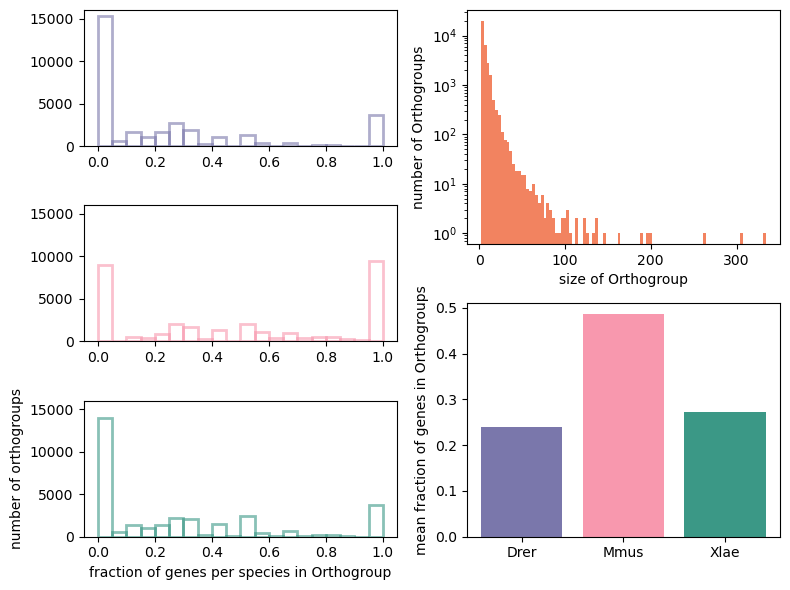

In [32]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import arcadia_pycolor as apc
import numpy as np
from matplotlib.gridspec import GridSpec

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=apc.arcadia_All_ordered.values())
mpl.rcParams['pdf.fonttype'] = 42


fig = plt.figure(figsize = (8, 6))
gs = GridSpec(6, 2, figure = fig)

fig.add_subplot(gs[0:3, 1])
plt.hist(og_df['size'].values, bins = 100, color = 'arcadia:amber', rasterized = True)
plt.yscale('log')
plt.ylabel('number of Orthogroups')
plt.xlabel('size of Orthogroup')

i = 0
for key, value in species_colordict.items():
    fig.add_subplot(gs[i:i+2, 0])
    plt.hist(og_df[key + '_fraction'].values, bins = np.arange(0, 1.05, 0.05), edgecolor = value, fill = False, alpha = 0.6, linewidth = 2)
    plt.ylim(0, 16000)
    i += 2
plt.xlabel('fraction of genes per species in Orthogroup')
plt.ylabel('number of orthogroups')

mean_fraction = [np.mean(og_df[x + '_fraction'].values) for x in species_colordict.keys()]
fig.add_subplot(gs[3:, 1])
plt.bar(list(species_colordict.keys()), mean_fraction, color = list(species_colordict.values()))
plt.ylabel('mean fraction of genes in Orthogroups')

plt.tight_layout()
plt.savefig('DrerMmusXlae_OG_stats_ALL.pdf', dpi = 300)
plt.show()

In [33]:
og_exclusive_df = pd.read_csv(sample_MSD.orthogroups_file.path, sep = '\t', names = ['Orthogroup', 'Mmus', 'Drer', 'Xlae'], skiprows = 1)
og_exclusive_df.dropna(inplace = True)

og_df = og_exclusive_df

species_colordict = {'Drer': 'arcadia:aster',
                    'Mmus': 'arcadia:rose',
                    'Xlae': 'arcadia:seaweed'}

col_unpacker = lambda x: x.split(',') if type(x) == str else []

for col in species_colordict.keys():
    og_df[col] = og_df[col].apply(col_unpacker)
    og_df[col + '_size'] = og_df[col].apply(lambda x: len(x))

og_df['full_list'] = og_df['Mmus'] + og_df['Drer'] + og_df['Xlae']
og_df['size'] = og_df['full_list'].apply(lambda x: len(x))

for col in species_colordict.keys():
    og_df[col + '_fraction'] = og_df[col + '_size'] / og_df['size']

display(og_df)

,Orthogroup,Mmus,Drer,Xlae,Drer_size,Mmus_size,Xlae_size,full_list,size,Drer_fraction,Mmus_fraction,Xlae_fraction
5,OG0000005,[rna41863.p1],"[gene36062.p1, gene36087.p1, gene36102.p1, ...","[rna30164.p1, rna30164.p2]",185,1,2,"[rna41863.p1, gene36062.p1, gene36087.p1, ge...",188,0.984043,0.005319,0.010638
18,OG0000018,"[gene44223.p3, gene4542.p1, rna58523.p1, rn...","[gene10201.p1, gene10303.p1, gene10463.p1, ...","[rna51471.p3, rna66895.p1, rna71785.p6, rna...",94,4,4,"[gene44223.p3, gene4542.p1, rna58523.p1, rn...",102,0.921569,0.039216,0.039216
23,OG0000023,"[id392828.p1, id392905.p1, id392908.p1, id3...",[id481675.p1],"[id128862.p1, id148079.p1, id236607.p1, id2...",1,7,88,"[id392828.p1, id392905.p1, id392908.p1, id3...",96,0.010417,0.072917,0.916667
25,OG0000025,"[rna108177.p1, rna108178.p1, rna108179.p1, ...",[rna42819.p1],[rna2786.p1],1,88,1,"[rna108177.p1, rna108178.p1, rna108179.p1, ...",90,0.011111,0.977778,0.011111
27,OG0000027,"[gene46590.p1, id1126495.p2, id1126508.p1, ...","[id72951.p1, id72954.p1, id72960.p1, id7296...","[id302444.p1, id376722.p1, id388578.p1, id4...",9,16,61,"[gene46590.p1, id1126495.p2, id1126508.p1, ...",86,0.104651,0.186047,0.709302
...,...,...,...,...,...,...,...,...,...,...,...,...
22949,OG0022949,[rna99619.p1],[rna25048.p1],[rna2163.p1],1,1,1,"[rna99619.p1, rna25048.p1, rna2163.p1]",3,0.333333,0.333333,0.333333
22951,OG0022951,[rna99628.p1],[rna25053.p1],[rna13541.p1],1,1,1,"[rna99628.p1, rna25053.p1, rna13541.p1]",3,0.333333,0.333333,0.333333
22952,OG0022952,[rna99792.p1],[rna25042.p1],[rna40831.p1],1,1,1,"[rna99792.p1, rna25042.p1, rna40831.p1]",3,0.333333,0.333333,0.333333
22960,OG0022960,[rna99936.p1],[rna8349.p1],[rna2083.p1],1,1,1,"[rna99936.p1, rna8349.p1, rna2083.p1]",3,0.333333,0.333333,0.333333


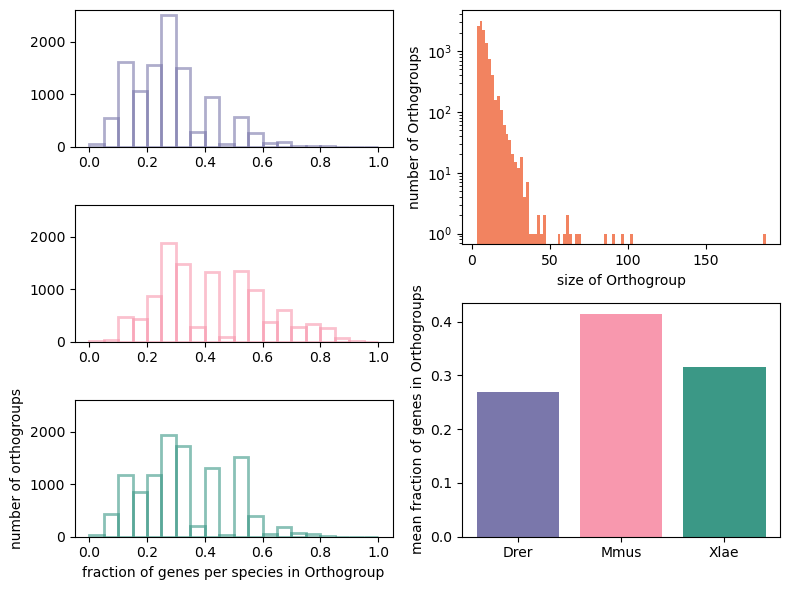

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import arcadia_pycolor as apc
import numpy as np
from matplotlib.gridspec import GridSpec

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=apc.arcadia_All_ordered.values())
mpl.rcParams['pdf.fonttype'] = 42


fig = plt.figure(figsize = (8, 6))
gs = GridSpec(6, 2, figure = fig)

fig.add_subplot(gs[0:3, 1])
plt.hist(og_df['size'].values, bins = 100, color = 'arcadia:amber', rasterized = True)
plt.yscale('log')
plt.ylabel('number of Orthogroups')
plt.xlabel('size of Orthogroup')

i = 0
for key, value in species_colordict.items():
    fig.add_subplot(gs[i:i+2, 0])
    plt.hist(og_df[key + '_fraction'].values, bins = np.arange(0, 1.05, 0.05), edgecolor = value, fill = False, alpha = 0.6, linewidth = 2)
    plt.ylim(0, 2600)
    i += 2
plt.xlabel('fraction of genes per species in Orthogroup')
plt.ylabel('number of orthogroups')

mean_fraction = [np.mean(og_df[x + '_fraction'].values) for x in species_colordict.keys()]
fig.add_subplot(gs[3:, 1])
plt.bar(list(species_colordict.keys()), mean_fraction, color = list(species_colordict.values()))
plt.ylabel('mean fraction of genes in Orthogroups')

plt.tight_layout()
plt.savefig('DrerMmusXlae_OG_stats.pdf', dpi = 300)
plt.show()

In [35]:
display(mean_fraction)

[0.2683726882395746, 0.4150460520920958, 0.3165812596683297]